# Classifier Predictive model  for Megaline user's plan selection

This document presents the overall process for creating, training and selecting a predictive model. Our final result will be a classifier, which will predict the best phone plan based on user consumption. Let's get started by importing our dependencies

## Dependencies

We are using pandas, seaborn and sklearn. 

In [2]:
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


## Common functions

As we face a binary classification problem we will have to calculate the TPR (True Positive Rate) and the FPR (Fake Positive Rate). We will use those values to make a ROC ( Receiver Operative Characteristic) plot to decide which model performs the best for our porpouse.
Our functions will use the confusion matrix to calculate our rates

In [3]:
def calculate_TPR(confusion_matrix):
    return confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[1][0])

def calculate_FPR(confusion_matrix):
    return (confusion_matrix[0][1])/(confusion_matrix[0][1]+confusion_matrix[1][1])
        

## Load and first glance: user_behavior.csv dataset

In [4]:
data = pd.read_csv('./data/users_behavior.csv')

In [5]:
data.duplicated().sum()

0

There is no duplicated data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [7]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Columns data type are ok and for this analysis we __UNFORTUNATELY__ will __NOT__ be converting our columns range into an scaled version.

<Axes: xlabel='is_ultra'>

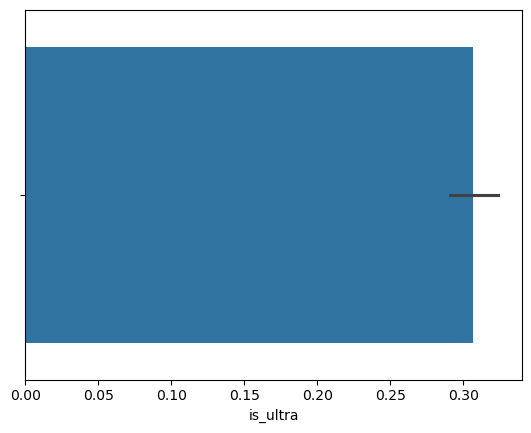

In [8]:
sns.barplot(data=data, x='is_ultra')

This dataset has a lot of non ultra users, that is somenthing we have to take into account when evaluating and training our model.

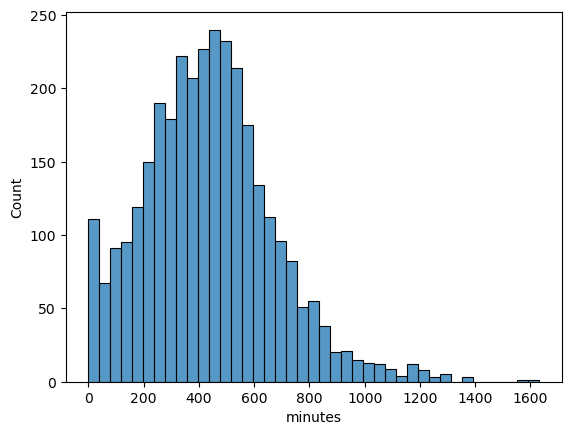

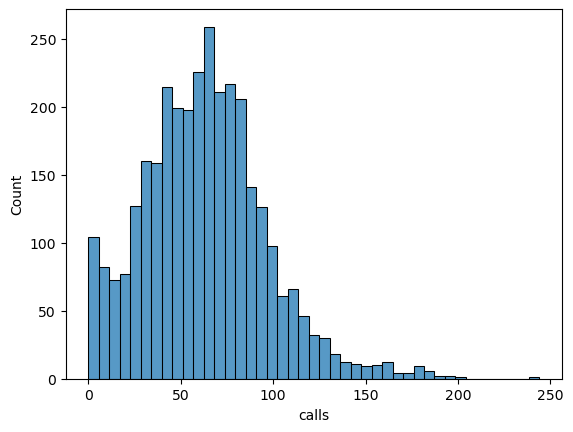

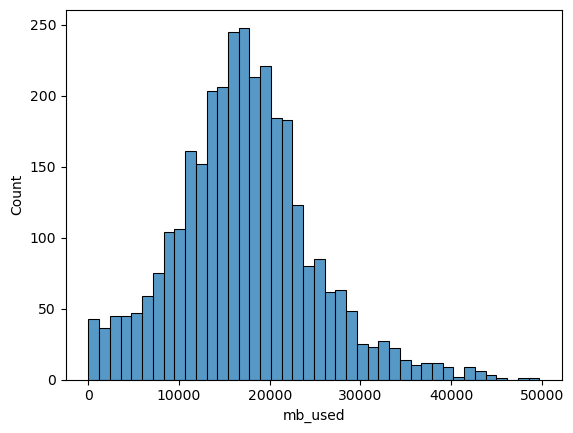

<Axes: xlabel='messages', ylabel='Count'>

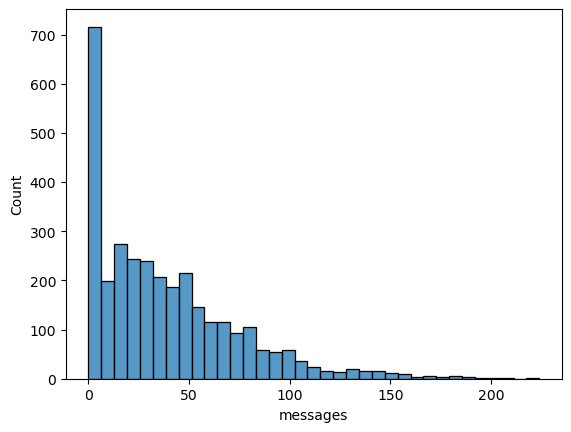

In [9]:

sns.histplot(data=data, x='minutes')
plt.show()
sns.histplot(data=data, x='calls')
plt.show()
sns.histplot(data=data, x='mb_used')
plt.show()
sns.histplot(data=data, x='messages')

From the histograms above, we can see the presence of too many outliers in more than one predictor column (all of them except is_ultra). However, __UNFORTUNATELY__ we will not address this problem. As a standard scaler will asume that our data follows a normal distribution in  this case a scaler based on percentils would be a great approach though. Now, let's continue splitting our dataset as is

In [10]:
features = data.drop(['is_ultra'], axis=1)
target = data[['is_ultra']]

In [11]:
training_features, validation_features, training_target, validation_target = train_test_split(features, target, test_size=0.25, random_state=12345)

## Model candidates

### Decision Tree Classifier:

Let's start by evaluating the feasibility of decision tree classifier. For that matter we will use a DataFrame to storage the evaluation metrics for our mmodel. Our hyperparameter `max_depth` will vary from 1 to 20 then we will check the TPR vs the FTR

In [12]:
tree_model_results = pd.DataFrame(columns=['max_depth', 'accuracy', 'training_accuracy', 'validation_accuracy', 'recall', 'precision', 'score'])
n= 1

for depth in range(1, 20):
    model = DecisionTreeClassifier(max_depth=depth)
    model.fit(training_features, training_target)
    
    
    tree_model_results.loc[n, 'max_depth'] = depth
    tree_model_results.loc[n, 'training_accuracy'] = model.score(training_features, training_target)
    tree_model_results.loc[n, 'validation_accuracy'] = model.score(validation_features, validation_target)

    predictions = model.predict(validation_features)
    tree_model_results.loc[n, 'TPR'] = calculate_TPR(confusion_matrix(validation_target, predictions))
    tree_model_results.loc[n, 'FPR'] = calculate_FPR(confusion_matrix(validation_target, predictions))
    n += 1
    
    

    

<Axes: xlabel='FPR', ylabel='TPR'>

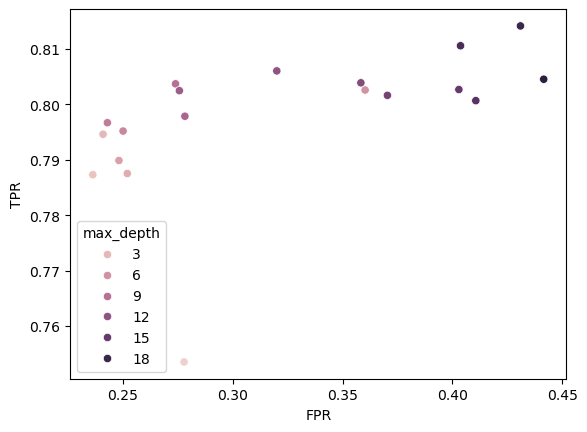

In [13]:
sns.scatterplot(data=tree_model_results, x='FPR', y='TPR', hue='max_depth')

Now let's talk about our OCR plot. There are two axis here, the y-axis represent how precise an ultra user will be correct predicted as ultra user, this is the same than the __precision__ metric. In the other hand we have the amount of those no ultra user identified as ultra.
Now is on us to decide which hyperparameter work the best for us, some hyperparam values are obviouslly a bad decision. Let's try to find an hyperparameter that maximize our TPR without affecting our FTR.

<Axes: xlabel='training_accuracy', ylabel='validation_accuracy'>

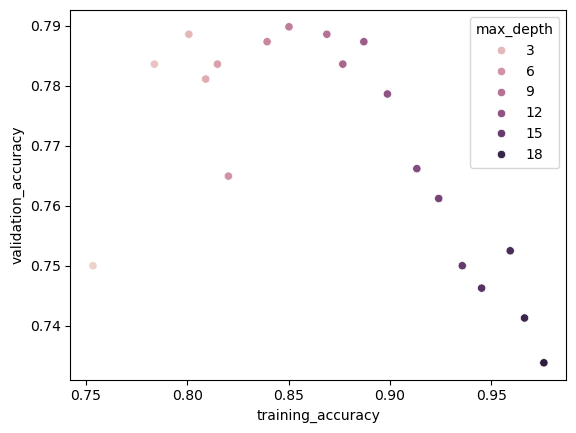

In [14]:
sns.scatterplot(data=tree_model_results, x='training_accuracy', y='validation_accuracy', hue='max_depth')

As we know it is important to evaluate the overfitting and underfitting conditions and in this case we can see that Decision tree classifiers are very likely to overfitting. Probably not the best option for this case  

### Random forest

For evaluating feasibility of random forest classifiers we will use a DataFrame to storage the evaluation metrics for our model. Our hyperparameter: `max_depth`, will vary from 1 to 20, then for each value of `max_depth`, the number of estimators (n_estimators) will vary from 1 to 20.

In [15]:
type(training_target.squeeze())

pandas.core.series.Series

In [16]:
random_forest_results = pd.DataFrame(columns=['max_depth', 'n_estimators', 'training_accuracy', 'validation_accuracy', 'TPR', 'FPR'])

for depth in range(1, 20):
    for estimators in range(1, 20):
        model = RandomForestClassifier(max_depth=depth, n_estimators = estimators)
        model.fit(training_features, training_target.squeeze())
        random_forest_results.loc[n, 'max_depth'] = depth
        random_forest_results.loc[n, 'n_estimators'] = estimators

        random_forest_results.loc[n, 'training_accuracy'] = model.score(training_features, training_target)
        random_forest_results.loc[n, 'validation_accuracy'] = model.score(validation_features, validation_target)

        predictions = model.predict(validation_features)
        random_forest_results.loc[n, 'TPR'] = calculate_TPR(confusion_matrix(predictions, validation_target))
        random_forest_results.loc[n, 'FPR'] = calculate_FPR(confusion_matrix(predictions, validation_target))
        n += 1
    

<Axes: xlabel='FPR', ylabel='TPR'>

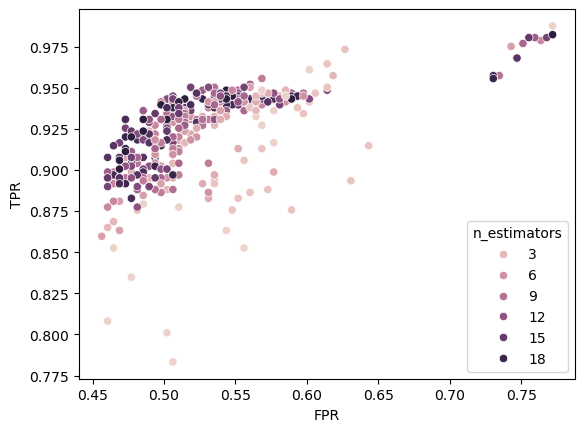

In [17]:
sns.scatterplot(data=random_forest_results, x='FPR', y='TPR', hue='n_estimators')

Now let's talk about our OCR plot. There are two axis here, the y-axis represent how precise an ultra user will be correct predicted as ultra user, this is the same than the __precision__ metric. In the other hand we have the amount of those no ultra user identified as ultra.
Now is on us to decide which hyperparameter work the best for us, some hyperparam values are obviouslly a bad decision. Let's try to find an hyperparameter that maximize our TPR without affecting our FPR.

<Axes: xlabel='training_accuracy', ylabel='validation_accuracy'>

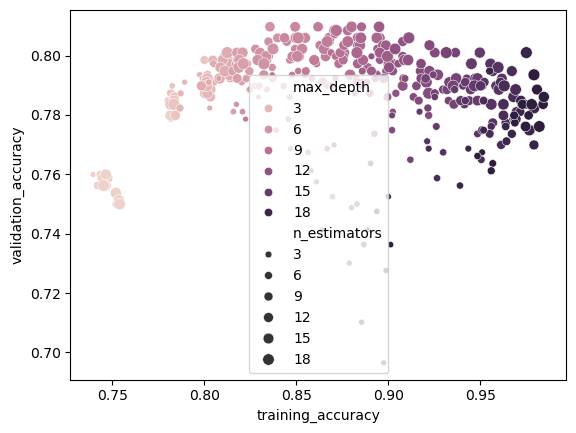

In [18]:
sns.scatterplot(data=random_forest_results, x='training_accuracy', y='validation_accuracy', hue='max_depth', size='n_estimators')

As we know it is important to evaluate the overfitting and underfitting conditions and in this case we can see that Decision tree classifiers are very likely to overfitting. In this case a forest with depth tree between 3 and 6 must be enough, and the number of the estimators higher than 6 should work

In [19]:
random_forest_results['validation_accuracy'] = pd.to_numeric(random_forest_results['validation_accuracy'])
random_forest_results['training_accuracy'] = pd.to_numeric(random_forest_results['training_accuracy'])

In [20]:
random_forest_results['overfitting'] = random_forest_results['validation_accuracy'] - random_forest_results['training_accuracy']  

In [21]:
random_forest_results['overfitting']

20     0.020531
21    -0.003136
22    -0.003942
23    -0.003942
24     0.016797
         ...   
376   -0.192356
377   -0.198578
378   -0.194426
379   -0.206038
380   -0.185721
Name: overfitting, Length: 361, dtype: float64

In [22]:
index_max = random_forest_results['overfitting'].idxmax()


In [23]:
random_forest_results.query('index==@index_max')

,max_depth,n_estimators,training_accuracy,validation_accuracy,TPR,FPR,overfitting
20,1,1,0.739419,0.75995,0.987567,0.771784,0.020531


<Axes: xlabel='training_accuracy', ylabel='validation_accuracy'>

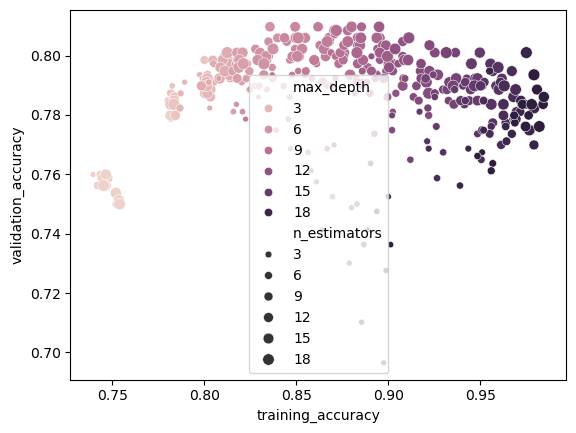

In [26]:
sns.scatterplot(data=random_forest_results, x='training_accuracy', y='validation_accuracy', hue='max_depth', size='n_estimators')

Based in the plot above a decent number of estimators will be 7 with a max_depth between 6 and 9. A model like that will give us a good validation accuracy. Now let's filter them.

In [52]:
random_forest_results.query('n_estimators==7')

,max_depth,n_estimators,training_accuracy,validation_accuracy,TPR,FPR,overfitting
26,1,7,0.728216,0.737562,0.994671,0.863071,0.009346
45,2,7,0.783402,0.786070,0.94849,0.593361,0.002667
64,3,7,0.806224,0.788557,0.946714,0.580913,-0.017667
83,4,7,0.813693,0.793532,0.937833,0.543568,-0.020161
102,5,7,0.820747,0.799751,0.94849,0.547718,-0.020996
121,6,7,0.834440,0.796020,0.936057,0.53112,-0.038420
140,7,7,0.845228,0.792289,0.941385,0.556017,-0.052940
159,8,7,0.865145,0.798507,0.932504,0.514523,-0.066638
178,9,7,0.869295,0.799751,0.932504,0.510373,-0.069543
197,10,7,0.879668,0.796020,0.932504,0.522822,-0.083648


#### Best random forest

Based in the previous table, we conclude that the set of hyperparamateres could work the best is:
 - n_estimators = 7 
 - max_depth = 9

### Logistic regression

Now it is time for logistic regression model, for this particular case we are going to use the confusion matrix and evaluate the TPR and FTR

In [53]:
model = LogisticRegression()
model.fit(training_features, training_target)
predictions = model.predict(validation_features)
print(confusion_matrix(validation_target, predictions))


[[556   7]
 [186  55]]


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [54]:
model.score(validation_features, validation_target)

0.7599502487562189

In [55]:
logistic_tpr = calculate_TPR(confusion_matrix(validation_target, predictions))
logistic_tpr

0.7493261455525606

In [56]:
logistic_fpr = calculate_FPR(confusion_matrix(validation_target, predictions))
logistic_fpr

0.11290322580645161

### Our best model:

Our best model would be the best random forest we described a couple cells before in the Random Forest Section

## Conclusion

Based in the process, let's make some conclutions.
- It is possible to optimize hyperparameters using basic control sentences.
- To evaluate and compare performance of machine learning models, it is usefull to split the dataset into two: training and validation (ensuring our model can be tested with data that has never before been seen).
- The evaluation metrics (TPR and FPR, accuracy...) are essential to establish benchmarks and to compare models. 
- Selecting the optimal model is one of the most important decisions we can make in data science.
- Comparing model performance in both training and validation data gives us a general idea if either the model is biased or not.